Nome: Luiz Henrique Lourenção

Nusp: 10284862

# Códigos do Professor

In [1]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 49.8 MB/s 


In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
df = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')

df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
# feature eng

df['AgeSold']      = df['YrSold'] - df['YearBuilt']
df['AgeRemodSold'] = df['YrSold'] - df['YearRemodAdd']
df['GarageAgeBlt'] = df['YrSold'] - df['GarageYrBlt']

# feature eng test

df_test['AgeSold']      = df_test['YrSold'] - df_test['YearBuilt']
df_test['AgeRemodSold'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_test['GarageAgeBlt'] = df_test['YrSold'] - df_test['GarageYrBlt']

In [5]:
target_col  = 'SalePrice'

future_cols = [
    'MoSold',
    'YrSold',
    'SaleType',
    'SaleCondition',
    target_col
]

drop_fe_cols = [
    'YearBuilt',
    'YearRemodAdd',
    'GarageYrBlt'
]

In [6]:
y = df['SalePrice']

# remover colunas futuras do X
X = df.drop(future_cols, axis=1)

# remove vars do feature eng
X.drop(drop_fe_cols, axis=1, inplace=True)
df_test.drop(drop_fe_cols, axis=1, inplace=True)
df_test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,AgeSold,AgeRemodSold,GarageAgeBlt
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,49,49,49.0
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,52,52,52.0
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,13,12,13.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.65,
    random_state=42
)

len(y_train), len(y_test)

(949, 511)

In [8]:
#             -> (df_num) -> imputer -> scaler -
# col_transf |                                  |-> model
#             -> (df_ceteg) -> one_hot_encoder - 

pipeline_num = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler' , MinMaxScaler())
    ]
)

ct = ColumnTransformer([
    (
        'num_transf', 
        pipeline_num, 
        make_column_selector(dtype_exclude=object)
    ),
    (
        'categ_transf', 
        OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        make_column_selector(dtype_include=object)
    )
])

pipeline = Pipeline(
    steps=[
        ('ct', ct),
        ('model'     , KNeighborsRegressor())
    ]
)

In [9]:
parameters = {
    # imputer params
    'ct__num_transf__imputer__strategy': ['mean', 'median'],
    
    # scaler params
    'ct__num_transf__scaler'           : [MinMaxScaler(), StandardScaler()],
    
    # model params
    'model__n_neighbors'               : [1, 7, 11, 23, 51],
    'model__weights'                   : ['uniform', 'distance'],
    'model__metric'                    : ['euclidean', 'manhattan', 'chebyshev']
}

In [10]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    cv=3,
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_transf',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7321c0ad0>),
                                                                        ('categ_transf',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                      

In [11]:
grid_search.best_params_

{'ct__num_transf__imputer__strategy': 'mean',
 'ct__num_transf__scaler': StandardScaler(),
 'model__metric': 'manhattan',
 'model__n_neighbors': 7,
 'model__weights': 'distance'}

In [12]:
grid_search.best_score_

-35591.91512293391

In [13]:
df_results = pd.DataFrame(grid_search.cv_results_)

df_results.to_excel('results.xlsx', index=False)

In [14]:
y_pred = grid_search.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

37218.16793199126

# Questão 1

## a)

In [15]:
# Primeira variável explicativa -> "FrontagePerArea" -> É a quantidade em pés (linear) de rua conectada à casa por pé quadrado da casa
# A ideia é tentar verificar se casas com maior porcentagem de area conectadas a rua, tendem a ter um valor maior
# Um valor de "FrontagePerArea" pode significar por exemplo que é uma casa de esquina, que tem bastante acesso à rua
# Possibilita a criação de portões para garagem, portões de acesso em locais diferentes, etc...
df['FrontagePerArea'] = df['LotFrontage'] / df['LotArea']
df_test['FrontagePerArea'] = df_test['LotFrontage'] / df_test['LotArea']

#A segunda variável explicativa -> "BuiltAreaPerLotArea" -> É a quantidade em pés quadrados de área construida por pé quadrado de area disponível
#Considerando aqui como área construida a soma do primeiro com o segundo andar da casa (para isso tive que criar uma variável auxiliar "TotalBuiltArea")
#A ideia aqui é identificar casas que utilizam bem o espaço do lote.
#Um lote gigantesco nem sempre significa que a casa tem um valor muito alto, pois ela poder ter pouca area construida e o resto do terreno muitas vezes com mato para cuidar, etc...
df['TotalBuiltArea'] = df['1stFlrSF'] + df['2ndFlrSF']
df['BuiltAreaPerLotArea'] = df['TotalBuiltArea'] / df['LotArea']
df_test['TotalBuiltArea'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['BuiltAreaPerLotArea'] = df_test['TotalBuiltArea'] / df_test['LotArea']

#A terceira e última variável explicativa -> "LowQualityPerBuiltArea" -> É a quantidade em pés quadrados de área construida com acabamento de baixa qualidade por área construida
#A ideia aqui é verificar a porcentagem de área construida que foi construida com acabamento de baixa qualidade
#O tamanho total de área construida pode fazer com que a variável original "LowQualFinSF" nos dê uma informação não tão precisa
#Uma "LowQualFinSF" alta numa casa com área construida muito grande deveria ser bem menos impactante do que uma "LowQualFinSF" alta numa casa com pouca area construida
df['LowQualityPerBuiltArea'] = df['LowQualFinSF'] / df['TotalBuiltArea']
df_test['LowQualityPerBuiltArea'] = df_test['LowQualFinSF'] / df_test['TotalBuiltArea']

# remover colunas futuras do X
X = df.drop(future_cols, axis=1)
# remove vars do feature eng
X.drop(drop_fe_cols, axis=1, inplace=True)

#Assim fica a base de dados depois da criação das novas variáveis explicativas
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,AgeSold,AgeRemodSold,GarageAgeBlt,FrontagePerArea,TotalBuiltArea,BuiltAreaPerLotArea,LowQualityPerBuiltArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,5,5,5.0,0.007692,1710,0.202367,0.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,31,31,31.0,0.008333,1262,0.131458,0.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,7,6,7.0,0.006044,1786,0.158756,0.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,91,36,8.0,0.006283,1717,0.179791,0.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,8,8,8.0,0.005891,2198,0.154137,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,7,8.0,0.007831,1647,0.208033,0.0
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,32,22,32.0,0.006452,2073,0.157343,0.0
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,69,4,69.0,0.007299,2340,0.258792,0.0


## b)

A análise textual ja está feita no item a)

Foi feita uma análise textual para cada variável acima da criação da mesma

Para fazer uma análise mais técnica, vou rodar novamente os algoritmos do professor e visualizar os valores finais

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.65,
    random_state=42
)

len(y_train), len(y_test)

(949, 511)

In [17]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,AgeSold,AgeRemodSold,GarageAgeBlt,FrontagePerArea,TotalBuiltArea,BuiltAreaPerLotArea,LowQualityPerBuiltArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,94,27,NaN,0.012397,1013,0.119599,0.506417
887,90,RL,70.0,8393,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,Duplex,1Story,5,5,Gable,CompShg,MetalSd,MetalSd,BrkFace,122.0,TA,TA,CBlock,TA,TA,No,LwQ,528,Unf,0,1098,1626,GasA,Ex,Y,SBrkr,1712,0,0,1712,0,0,2,0,4,2,TA,8,Typ,0,NaN,Attchd,Fin,2,588,TA,TA,Y,272,54,0,0,0,0,NaN,NaN,NaN,0,47,1,1.0,0.008340,1712,0.203980,0.000000
553,20,RL,87.0,11146,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,Stone,250.0,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1709,1709,GasA,Ex,Y,SBrkr,1717,0,0,1717,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,RFn,3,908,TA,TA,Y,169,39,0,0,0,0,NaN,NaN,NaN,0,3,3,3.0,0.007805,1717,0.154046,0.000000
631,70,RM,50.0,9000,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,2Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,Fa,Fa,No,Unf,0,Unf,0,636,636,GasA,TA,Y,FuseA,1089,661,0,1750,0,0,1,0,3,1,Ex,8,Typ,0,NaN,Detchd,Unf,1,240,Fa,Po,N,0,0,293,0,0,0,NaN,MnPrv,NaN,0,126,15,69.0,0.005556,1750,0.194444,0.000000
1353,50,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,6,9,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,698,698,GasA,TA,Y,SBrkr,786,390,0,1176,0,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,Unf,2,624,TA,TA,N,210,0,0,0,0,0,NaN,NaN,NaN,0,72,9,10.0,0.008333,1176,0.196000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,24,Unf,0,1290,1314,GasA,Gd,Y,SBrkr,1314,0,0,1314,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,RFn,2,440,TA,TA,Y,0,22,0,0,0,0,NaN,NaN,NaN,0,1,1,1.0,0.008372,1314,0.141033,0.000000
1131,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,4,3,Gable,CompShg,WdShing,Plywood,None,0.0,TA,TA,BrkTil,TA,TA,No,BLQ,622,Unf,0,500,1122,GasA,TA,Y,SBrkr,1328,653,0,1981,1,0,2,0,4,1,Gd,7,Min2,2,TA,Detchd,Unf,2,576,TA,TA,Y,431,44,0,0,0,0,NaN,MnPrv,NaN,0,81,59,28.0,0.008329,1981,0.253844,0.000000
1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,Hip,CompShg,WdShing,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,167,Unf,0,697,864,GasA,TA,Y,SBrkr,864,0,0,864,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,Unf,2,572,TA,TA,N,0,0,0,0,0,0,NaN,NaN,NaN,0,51,16,49.0,0.007342,864,0.105727,0.000000


In [18]:
#             -> (df_num) -> imputer -> scaler -
# col_transf |                                  |-> model
#             -> (df_ceteg) -> one_hot_encoder - 

pipeline_num = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler' , MinMaxScaler())
    ]
)

ct = ColumnTransformer([
    (
        'num_transf', 
        pipeline_num, 
        make_column_selector(dtype_exclude=object)
    ),
    (
        'categ_transf', 
        OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        make_column_selector(dtype_include=object)
    )
])

pipeline = Pipeline(
    steps=[
        ('ct', ct),
        ('model'     , KNeighborsRegressor())
    ]
)

In [19]:
parameters = {
    # imputer params
    'ct__num_transf__imputer__strategy': ['mean', 'median'],
    
    # scaler params
    'ct__num_transf__scaler'           : [MinMaxScaler(), StandardScaler()],
    
    # model params
    'model__n_neighbors'               : [1, 7, 11, 23, 51],
    'model__weights'                   : ['uniform', 'distance'],
    'model__metric'                    : ['euclidean', 'manhattan', 'chebyshev']
}

In [20]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    cv=3,
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_transf',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa72819ad90>),
                                                                        ('categ_transf',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                      

In [21]:
grid_search.best_params_

{'ct__num_transf__imputer__strategy': 'median',
 'ct__num_transf__scaler': StandardScaler(),
 'model__metric': 'manhattan',
 'model__n_neighbors': 7,
 'model__weights': 'distance'}

In [22]:
grid_search.best_params_

{'ct__num_transf__imputer__strategy': 'median',
 'ct__num_transf__scaler': StandardScaler(),
 'model__metric': 'manhattan',
 'model__n_neighbors': 7,
 'model__weights': 'distance'}

In [23]:
grid_search.best_score_

-35094.16642966966

In [24]:
y_pred = grid_search.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

36406.20933625335

Para felicidade de todos, as novas variáveis criadas tiveram um impacto positivo no valor final do erro médio do algoritmo, finalizando assim a análise técnica das variáveis

# Questão 2

## a) e b)

In [25]:
#             -> (df_num) -> imputer -> scaler -
# col_transf |                                  |-> model
#             -> (df_ceteg) -> one_hot_encoder - 

pipeline_num = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler' , MinMaxScaler())
    ]
)

ct = ColumnTransformer([
    (
        'num_transf', 
        pipeline_num, 
        make_column_selector(dtype_exclude=object)
    ),
    (
        'categ_transf', 
        OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        make_column_selector(dtype_include=object)
    )
])

pipeline_knn = Pipeline(
    steps=[
        ('ct', ct),
        ('model'     , KNeighborsRegressor())
    ]
)

#             -> (df_num) -> imputer -> scaler -
# col_transf |                                  |-> model
#             -> (df_ceteg) -> one_hot_encoder - 

pipeline_num = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler' , MinMaxScaler())
    ]
)

ct = ColumnTransformer([
    (
        'num_transf', 
        pipeline_num, 
        make_column_selector(dtype_exclude=object)
    ),
    (
        'categ_transf', 
        OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        make_column_selector(dtype_include=object)
    )
])

pipeline_tree = Pipeline(
    steps=[
        ('ct', ct),
        ('model'     , DecisionTreeRegressor())
    ]
)

#             -> (df_num) -> imputer -> scaler -
# col_transf |                                  |-> model
#             -> (df_ceteg) -> one_hot_encoder - 

pipeline_num = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler' , MinMaxScaler())
    ]
)

ct = ColumnTransformer([
    (
        'num_transf', 
        pipeline_num, 
        make_column_selector(dtype_exclude=object)
    ),
    (
        'categ_transf', 
        OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        make_column_selector(dtype_include=object)
    )
])

pipeline_svr = Pipeline(
    steps=[
        ('ct', ct),
        ('model'     ,SVR())
    ]
)

pipeline = [pipeline_knn, pipeline_tree, pipeline_svr]

In [26]:
parameters_knn = {
    # imputer params
    'ct__num_transf__imputer__strategy': ['mean', 'median'],
    
    # scaler params
    'ct__num_transf__scaler'           : [MinMaxScaler(), StandardScaler()],
    
    # model params
    'model__n_neighbors'               : [1, 7, 11, 23, 51],
    'model__weights'                   : ['uniform', 'distance'],
    'model__metric'                    : ['euclidean', 'manhattan', 'chebyshev'],

    'model'                            : [KNeighborsRegressor()]
}

parameters_tree = {
    # imputer params
    'ct__num_transf__imputer__strategy': ['mean', 'median'],
    
    # scaler params
    'ct__num_transf__scaler'           : [MinMaxScaler(), StandardScaler()],
    
    # model params
    'model__min_samples_leaf' : [10, 50, 100],
    'model__splitter'         : ['random', 'best'],
    'model__ccp_alpha'        : [0, 1],

    'model'              : [DecisionTreeRegressor()]
}

parameters_svr = {
    # imputer params
    'ct__num_transf__imputer__strategy': ['mean', 'median'],
    
    # scaler params
    'ct__num_transf__scaler'           : [MinMaxScaler(), StandardScaler()],
    
    # model params
    'model__C': [0.01, 0.1, 1.0],
    'model__kernel': ['rbf', 'poly'],
    'model__gamma': [0.01, 0.1, 1.0],

    'model'              : [SVR()]
}

parameters = [parameters_knn, parameters_tree, parameters_svr]

In [27]:
for i in range(len(pipeline)):
  grid_search = GridSearchCV(
      estimator=pipeline[i],
      param_grid=parameters[i],
      scoring='neg_root_mean_squared_error',
      cv=3,
  )

  grid_search.fit(X_train, y_train)
  print(grid_search.best_params_)
  y_pred = grid_search.predict(X_test)
  print(mean_squared_error(y_test, y_pred, squared=False))

{'ct__num_transf__imputer__strategy': 'median', 'ct__num_transf__scaler': StandardScaler(), 'model': KNeighborsRegressor(metric='manhattan', n_neighbors=7, weights='distance'), 'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'distance'}
36406.20933625335
{'ct__num_transf__imputer__strategy': 'mean', 'ct__num_transf__scaler': MinMaxScaler(), 'model': DecisionTreeRegressor(ccp_alpha=1, min_samples_leaf=10, splitter='random'), 'model__ccp_alpha': 1, 'model__min_samples_leaf': 10, 'model__splitter': 'random'}
41023.33513999875
{'ct__num_transf__imputer__strategy': 'mean', 'ct__num_transf__scaler': MinMaxScaler(), 'model': SVR(gamma=1.0, kernel='poly'), 'model__C': 1.0, 'model__gamma': 1.0, 'model__kernel': 'poly'}
33254.41851682498


In [28]:
#grid_search = GridSearchCV(
#    estimator=pipeline,
#    param_grid=parameters,
#    scoring='neg_root_mean_squared_error',
#    cv=3,
#)

#grid_search.fit(X_train, y_train)

######## Tentei fazer os dois modelos rodarem no mesmo gridsearch mas não consegui, então fiz dentro de um for (na célula a cima) para alternar entre os modelos

Questão 2 - B ja foi feita nas celulas acima adicionei o Support Vector Machines Regressor, que não tinhamos visto em aula

# Questão 3

##a)

Foram comparados os modelos : KNeighborsRegressor, DecisionTreeRegressor e SVR (Support Vector Machines Regressor). Cada um deles foi testado com vários parâmetros diferentes.

O modelo que teve a melhor performance foi o SVR. Os parâmetros e o valor obtido de RMSE podem ser encontrados na ultima célula de código executado da Questão 2.

RMSE obtido no caso foi: 33254

##b)

In [29]:
grid_search = GridSearchCV(
    estimator=pipeline[2],
    param_grid=parameters[2],
    scoring='neg_root_mean_squared_error',
    cv=3,
)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_transf',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa72810df90>),
                                                                        ('categ_transf',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                      

In [30]:
final_predictions = grid_search.predict(df_test)

In [31]:
output = pd.DataFrame({'Id': df_test.index, 'SalePrice': final_predictions})
output.to_csv('my_submission.csv', index=False)

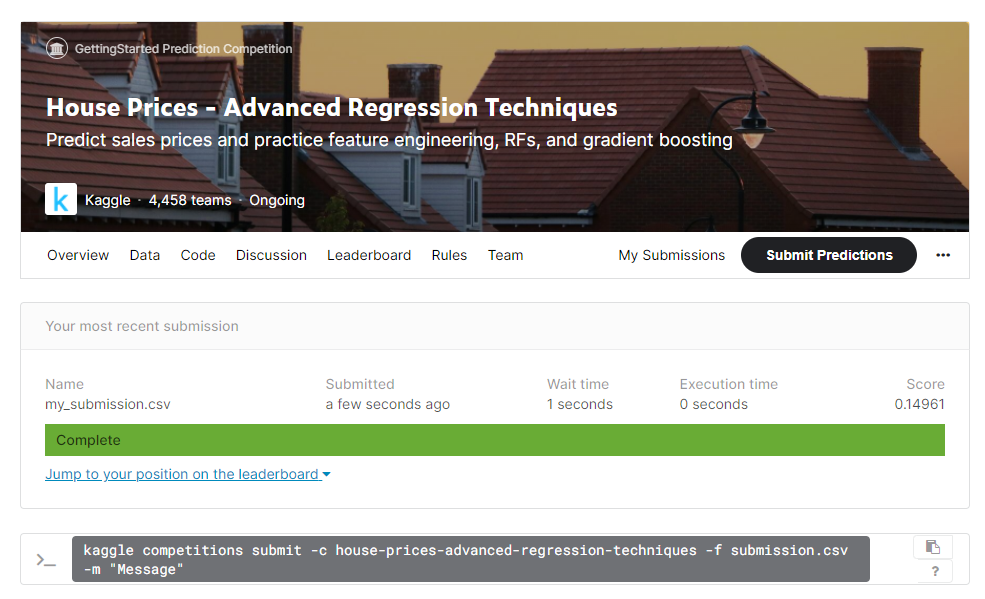

# Questão 4

##a)

O RMSE lida com os valores dos erros ao quadrado, portanto, um erro com uma magnitude muito alta tem peso muito maior do que um erro de baixa magnitude.

Isso faz com que o RMSE seja uma boa métrica pois da muita importância a erros muito grandes (que indicam um modelo ruim). Porém isso também faz com que o RMSE seja muito sensível a Outliers, pois eles elevam muito o valor dessa medida.

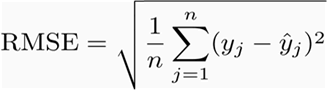

A fórmula acima é simplificada para fins didáticos.

Nessa fórmula, podemos ver que a média é calculada baseada na diferença de valor do "target" original para o "target" que o modelo previu. Porém, esse valor está ao quadrado. No caso de um Outlier, geralmente esse valor iria dar muito alto, afetando muito intensamente o valor da média.

##b)

Uma outra métrica muito utilizada na Ciência de Dados é o MAE. O MAE é uma medida razoavelmente parecida ao RMSE, pois também é calculada a média das diferenças dos valores originais dos previstos pelo modelo, porém, essa diferença não está elevada ao quadrado.

Por um lado, essa média penaliza pouco os erros de maiores magnitudes, o que pode ser prejudicial para a análise de qualidade de um modelo (pode parecer que o modelo é melhor do que realmente é). Porém, ela é menos sensível aos Outliers, que é o principal problema da outra medida.

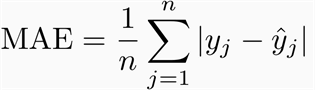

Acima, a fórmula simplificada do MAE.

Vale a pena citar que provavelmente o ideal seria utilizar as duas métricas e observar os resultados para tentar identificar informações incorretas ou imprecisas. Não é interessante sempre buscar pelo menor valor de RMSE ou MAE, pois isso pode mascarar um modelo não tão eficiente. O que buscamos é um modelo que será capaz de prever com eficiência novas instâncias do problema, das quais não conhecemos o "target".